# Beta + Double Gaussian Model: mu to break degeneracy
### 70 Injection Results
Break degeneracy by requiring mu1_cost<0 and mu2_cost>0

In [1]:
import json
import glob
import matplotlib.pylab as plt
import numpy as np
from scipy.special import erf
import sys
import pandas as pd
from scipy.stats import gaussian_kde
import random


sys.path.append('../../scripts/')
from makeCorner import *
from drawChiEff import *
from posterior_helper_functions import calculate_Gaussian_1D

import warnings
warnings.filterwarnings("ignore")

In [2]:
deg = '_mu' # _mu or _sigma

Load `.json` results file which contains
1. direct output from `emcee` interference, without any processing
2. post-processed output from `emcee` inference

In [3]:
# priorDict = {
# 'mu_chi':(0., 1.),
# 'sigma_chi':(0.05, 0.8),
# 'mu1_cost':(-1., 1.),
# 'sigma1_cost':(0.1, 0.5),
# 'mu2_cost':(-1., 1.),
# 'sigma2_cost':(0.1, 0.5), 
# 'MF_cost':(0., 1.)
# }

# # initial walker constraints
# if pop == '1':
#     initial_mu_chis = draw_initial_walkers_uniform(nWalkers, (0.54,0.56))
#     initial_sigma_chis = draw_initial_walkers_uniform(nWalkers, (0.25,0.27))
#     initial_MFs = draw_initial_walkers_uniform(nWalkers, (0.54, 0.56))
#     initial_Bqs = draw_initial_walkers_uniform(nWalkers, (1.37, 1.38))
#     initial_sigma1_costs = draw_initial_walkers_uniform(nWalkers, (0.17,0.19))
#     initial_sigma2_costs = draw_initial_walkers_uniform(nWalkers, (0.74,0.76))
    
#     # doesn't run if I only set mu1_cost to be -0.5, 0 and set mu2_cost to be strictly around true value
#     # also doesn't run if I set mu1_cost (-0.5, 0), mu2_cost to (0, 0.5)
#     initial_mu1_costs = draw_initial_walkers_uniform(nWalkers, (-0.5,0))
#     initial_mu2_costs = draw_initial_walkers_uniform(nWalkers, (0,0.5))

# elif pop == '2':
#     initial_mu_chis = draw_initial_walkers_uniform(nWalkers, (0.31,0.33))
#     initial_sigma_chis = draw_initial_walkers_uniform(nWalkers, (0.15,0.17))        
#     initial_MFs = draw_initial_walkers_uniform(nWalkers, (0.35,0.37))
#     initial_Bqs = draw_initial_walkers_uniform(nWalkers, (1.04,1.06))
#     initial_sigma1_costs = draw_initial_walkers_uniform(nWalkers, (0.63,0.65))
#     initial_sigma2_costs = draw_initial_walkers_uniform(nWalkers, (0.39,0.42))
    
#     # doesn't run if I only set mu1_cost to be -0.5, 0 and set mu2_cost to be strictly around true value
#     # also doesn't run if I set mu1_cost (-0.5, 0), mu2_cost to (0, 0.5)
#     initial_mu1_costs = draw_initial_walkers_uniform(nWalkers, (-0.5,0))
#     initial_mu2_costs = draw_initial_walkers_uniform(nWalkers, (0.31,0.6))

# elif pop == '3':
#     initial_mu_chis = draw_initial_walkers_uniform(nWalkers, (0.18,0.2))
#     initial_sigma_chis = draw_initial_walkers_uniform(nWalkers, (0.11,0.13))
#     initial_sigma1_costs = draw_initial_walkers_uniform(nWalkers, (0.43,0.45))
#     initial_sigma2_costs = draw_initial_walkers_uniform(nWalkers, (0.3,0.32))
#     initial_MFs = draw_initial_walkers_uniform(nWalkers, (0.25,0.27))
#     initial_Bqs = draw_initial_walkers_uniform(nWalkers, (1.21,1.23))
    
#     # strict initial walker constraints around true parameters
#     initial_mu1_costs = draw_initial_walkers_uniform(nWalkers, (-1,-0.99))
#     initial_mu2_costs = draw_initial_walkers_uniform(nWalkers, (0.99,1))


In [4]:
numinjections = '70'
model = 'double_gaussian' + deg
data_folder = "/home/zoe.ko/LIGOSURF22/data/70injections/70beta_doublegaus"+deg+"/" 

In [5]:
all_data = []
for pop in np.array([1, 2, 3]):
    pop = str(pop)
    name = data_folder + numinjections + "pop" + pop + model
    with open(f'{name}.json', 'r') as f:
        pop_data = json.load(f)
        all_data += [pop_data]
        
pop1_data = all_data[0]
pop2_data = all_data[1]
pop3_data = all_data[2]

In [6]:
with open('/home/zoe.ko/LIGOSURF22/input/70injections/sampleDict_pop1.json', 'r') as f:
    d = json.load(f)

The contents of this file are the following:

| Parameter (dict key) | Description |
| :-------- | :---------- |
| `mu_chi` | Mean of the spin magnitude Beta distribution|
| `sigma_chi` | Standard deviation of the spin magnitude Beta distribution |
| `mu1_cost` |  Mean of the first Gaussian in the $\cos\theta$ double Gaussian distribution |
| `sigma1_cost` |  Standard deviation of the first Gaussian in the $\cos\theta$ double Gaussian distribution |
| `mu2_cost` |  Mean of the second Gaussian in the $\cos\theta$ double Gaussian distribution |
| `sigma2_cost` |  Standard deviation of the second Gaussian in the $\cos\theta$ double Gaussian distribution |
| `MF_cost` |  Mixing fraction of the $\cos\theta$ double Gaussian distribution |
| `Bq` | Power-law index on the conditional secondary mass distribution $p(m_2 | m_1)$|

Next, plot our various chains to inspect convergence:

In [7]:
pop3_data.keys()

dict_keys(['mu_chi', 'sigma_chi', 'mu1_cost', 'sigma1_cost', 'mu2_cost', 'sigma2_cost', 'MF_cost', 'Bq', 'Neff', 'minNsamps', 'logL'])

In [8]:
len(pop3_data['mu_chi']['processed'])

420

pop 1


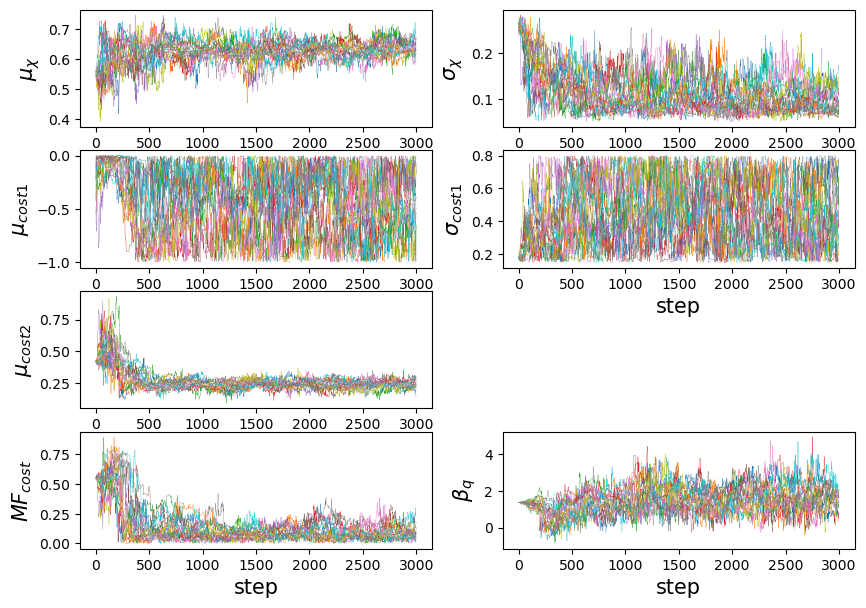

pop 2


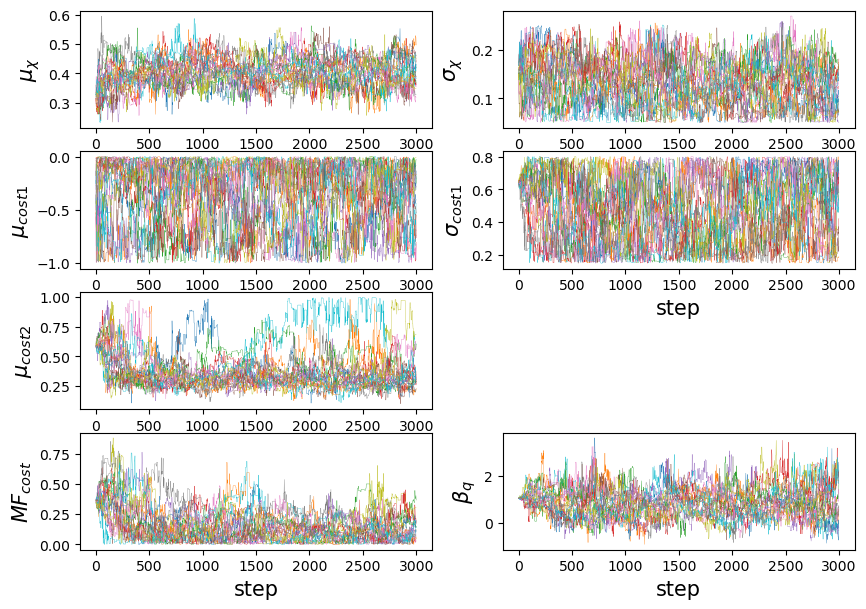

pop 3


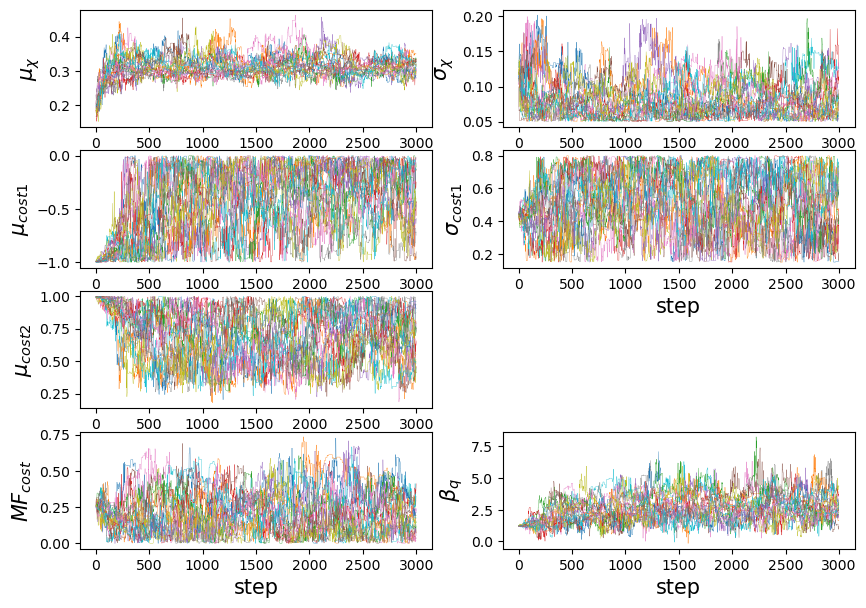

In [9]:
for i in np.arange(3):
    pop = str(i + 1)
    data = all_data[i] # HARD CODED
    print(f'pop {pop}')
    
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,7))

    # mu_chi
    for chain in data['mu_chi']['unprocessed']:
        axes[0][0].plot(chain, lw=0.25)
    axes[0][0].set_ylabel(r'$\mu_\chi$', fontsize=15)

    # sigma_chi
    for chain in data['sigma_chi']['unprocessed']:
        axes[0][1].plot(chain, lw=0.25)
    axes[0][1].set_ylabel(r'$\sigma_\chi$', fontsize=15)
    
    # mu_cost
    for chain in data['mu1_cost']['unprocessed']:
        axes[1][0].plot(chain, lw=0.25)
    axes[1][0].set_ylabel(r'$\mu_{cost 1}$', fontsize=15)
    
    # sigma_cost
    for chain in data['sigma1_cost']['unprocessed']:
        axes[1][1].plot(chain, lw=0.25)
    axes[1][1].set_ylabel(r'$\sigma_{cost 1}$', fontsize=15)
    
    # mu_cost2
    for chain in data['mu2_cost']['unprocessed']:
        axes[2][0].plot(chain, lw=0.25)
    axes[2][0].set_ylabel(r'$\mu_{cost 2}$', fontsize=15)
    
    # sigma_cost2
    for chain in data['sigma2_cost']['unprocessed']:
        axes[2][1].plot(chain, lw=0.25)
    axes[2][1].set_ylabel(r'$\sigma_{cost 2}$', fontsize=15)
 
    # MF_cost
    for chain in data['MF_cost']['unprocessed']:
        axes[3][0].plot(chain, lw=0.25)
    axes[3][0].set_ylabel(r'$MF_{cost}$', fontsize=15)
    
    # beta_q
    for chain in data['Bq']['unprocessed']:
        axes[3][1].plot(chain, lw=0.25)
    axes[3][1].set_ylabel(r'$\beta_{q}$', fontsize=15)

    for ax in axes: 
        for a in ax:
            a.set_xlabel('step', fontsize=15)       

    axes[2][1].set_visible(False)

    plt.show()

Let's make a corner plot showing posteriors on our parameters:

pop 1


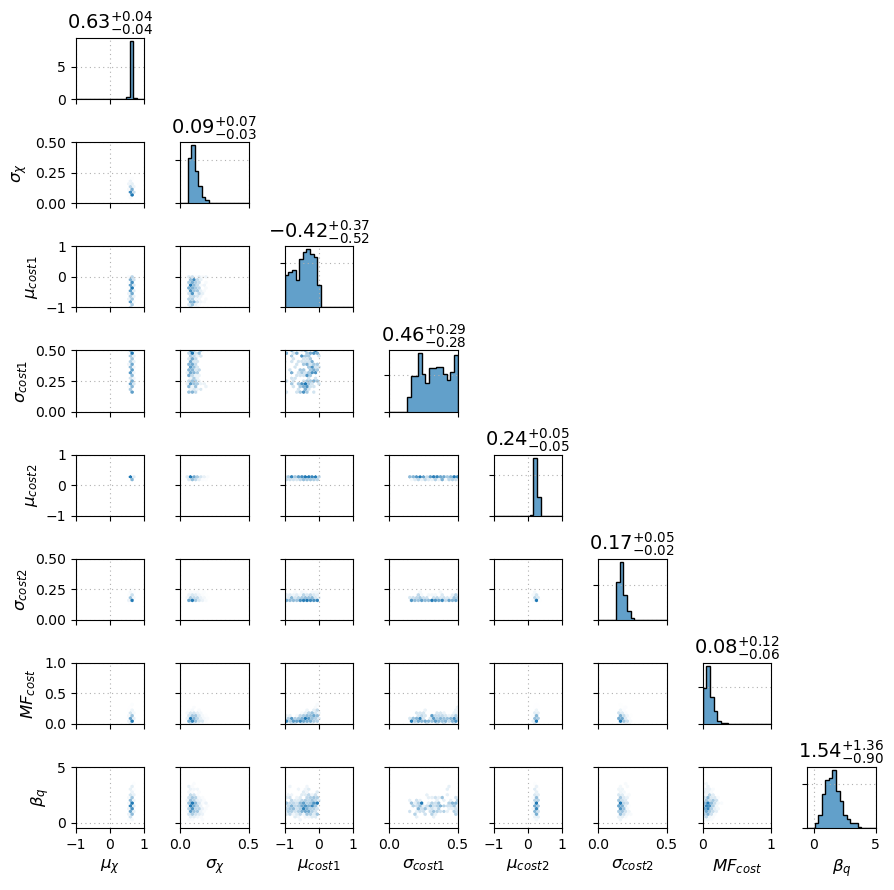

pop 2


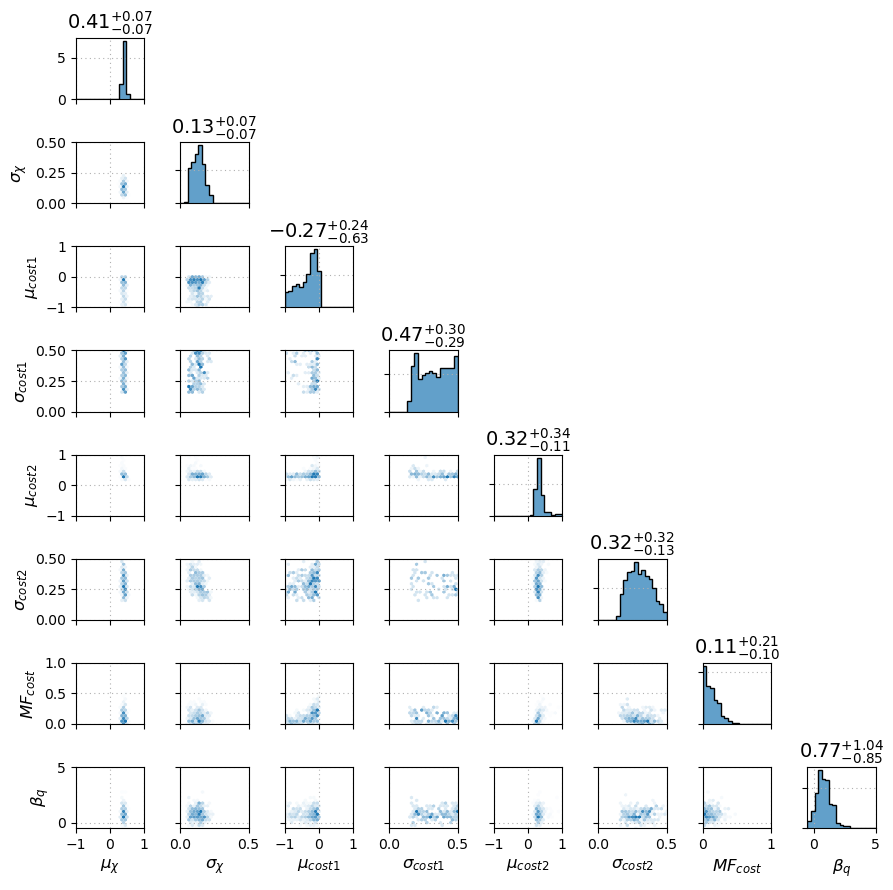

pop 3


In [ ]:
for i in np.arange(3):
    pop = str(i + 1)
    data = all_data[i]
    print(f'pop {pop}')
    
    fig = plt.figure(figsize=(9,9))

    toPlot = {
        "mu_chi":{"data":data['mu_chi']['processed'], "plot_bounds":(-1,1), "label":r"$\mu_\chi$"},
        "sigma_chi":{"data":data['sigma_chi']['processed'], "plot_bounds":(0,0.5), "label":r"$\sigma_\chi$" },
        "mu_cost 1":{"data":data['mu1_cost']['processed'], "plot_bounds":(-1,1), "label":r"$\mu_{cost 1}$"},
        "sigma_cost 1":{"data":data['sigma1_cost']['processed'], "plot_bounds":(0,0.5), "label":r"$\sigma_{cost 1}$" },
        "mu_cost 2":{"data":data['mu2_cost']['processed'], "plot_bounds":(-1,1), "label":r"$\mu_{cost 2}$"},
        "sigma_cost 2":{"data":data['sigma2_cost']['processed'], "plot_bounds":(0,0.5), "label":r"$\sigma_{cost 2}$" },
        "MF_cost":{"data":np.asarray(data['MF_cost']['processed']), "plot_bounds":(0,1), "label":r"$MF_{cost}$" },
        "Bq":{"data":data['Bq']['processed'], "plot_bounds":(-0.5,5), "label":r"$\beta_q$" },
    }

    plot_corner(fig,toPlot,'#1f78b4',labelsize=12)
    plt.tight_layout()
    plt.show()

Finally, let's make a "trace plot" showing the set of $\chi$ and $\cos \theta$ distributions corresponding to the above samples:

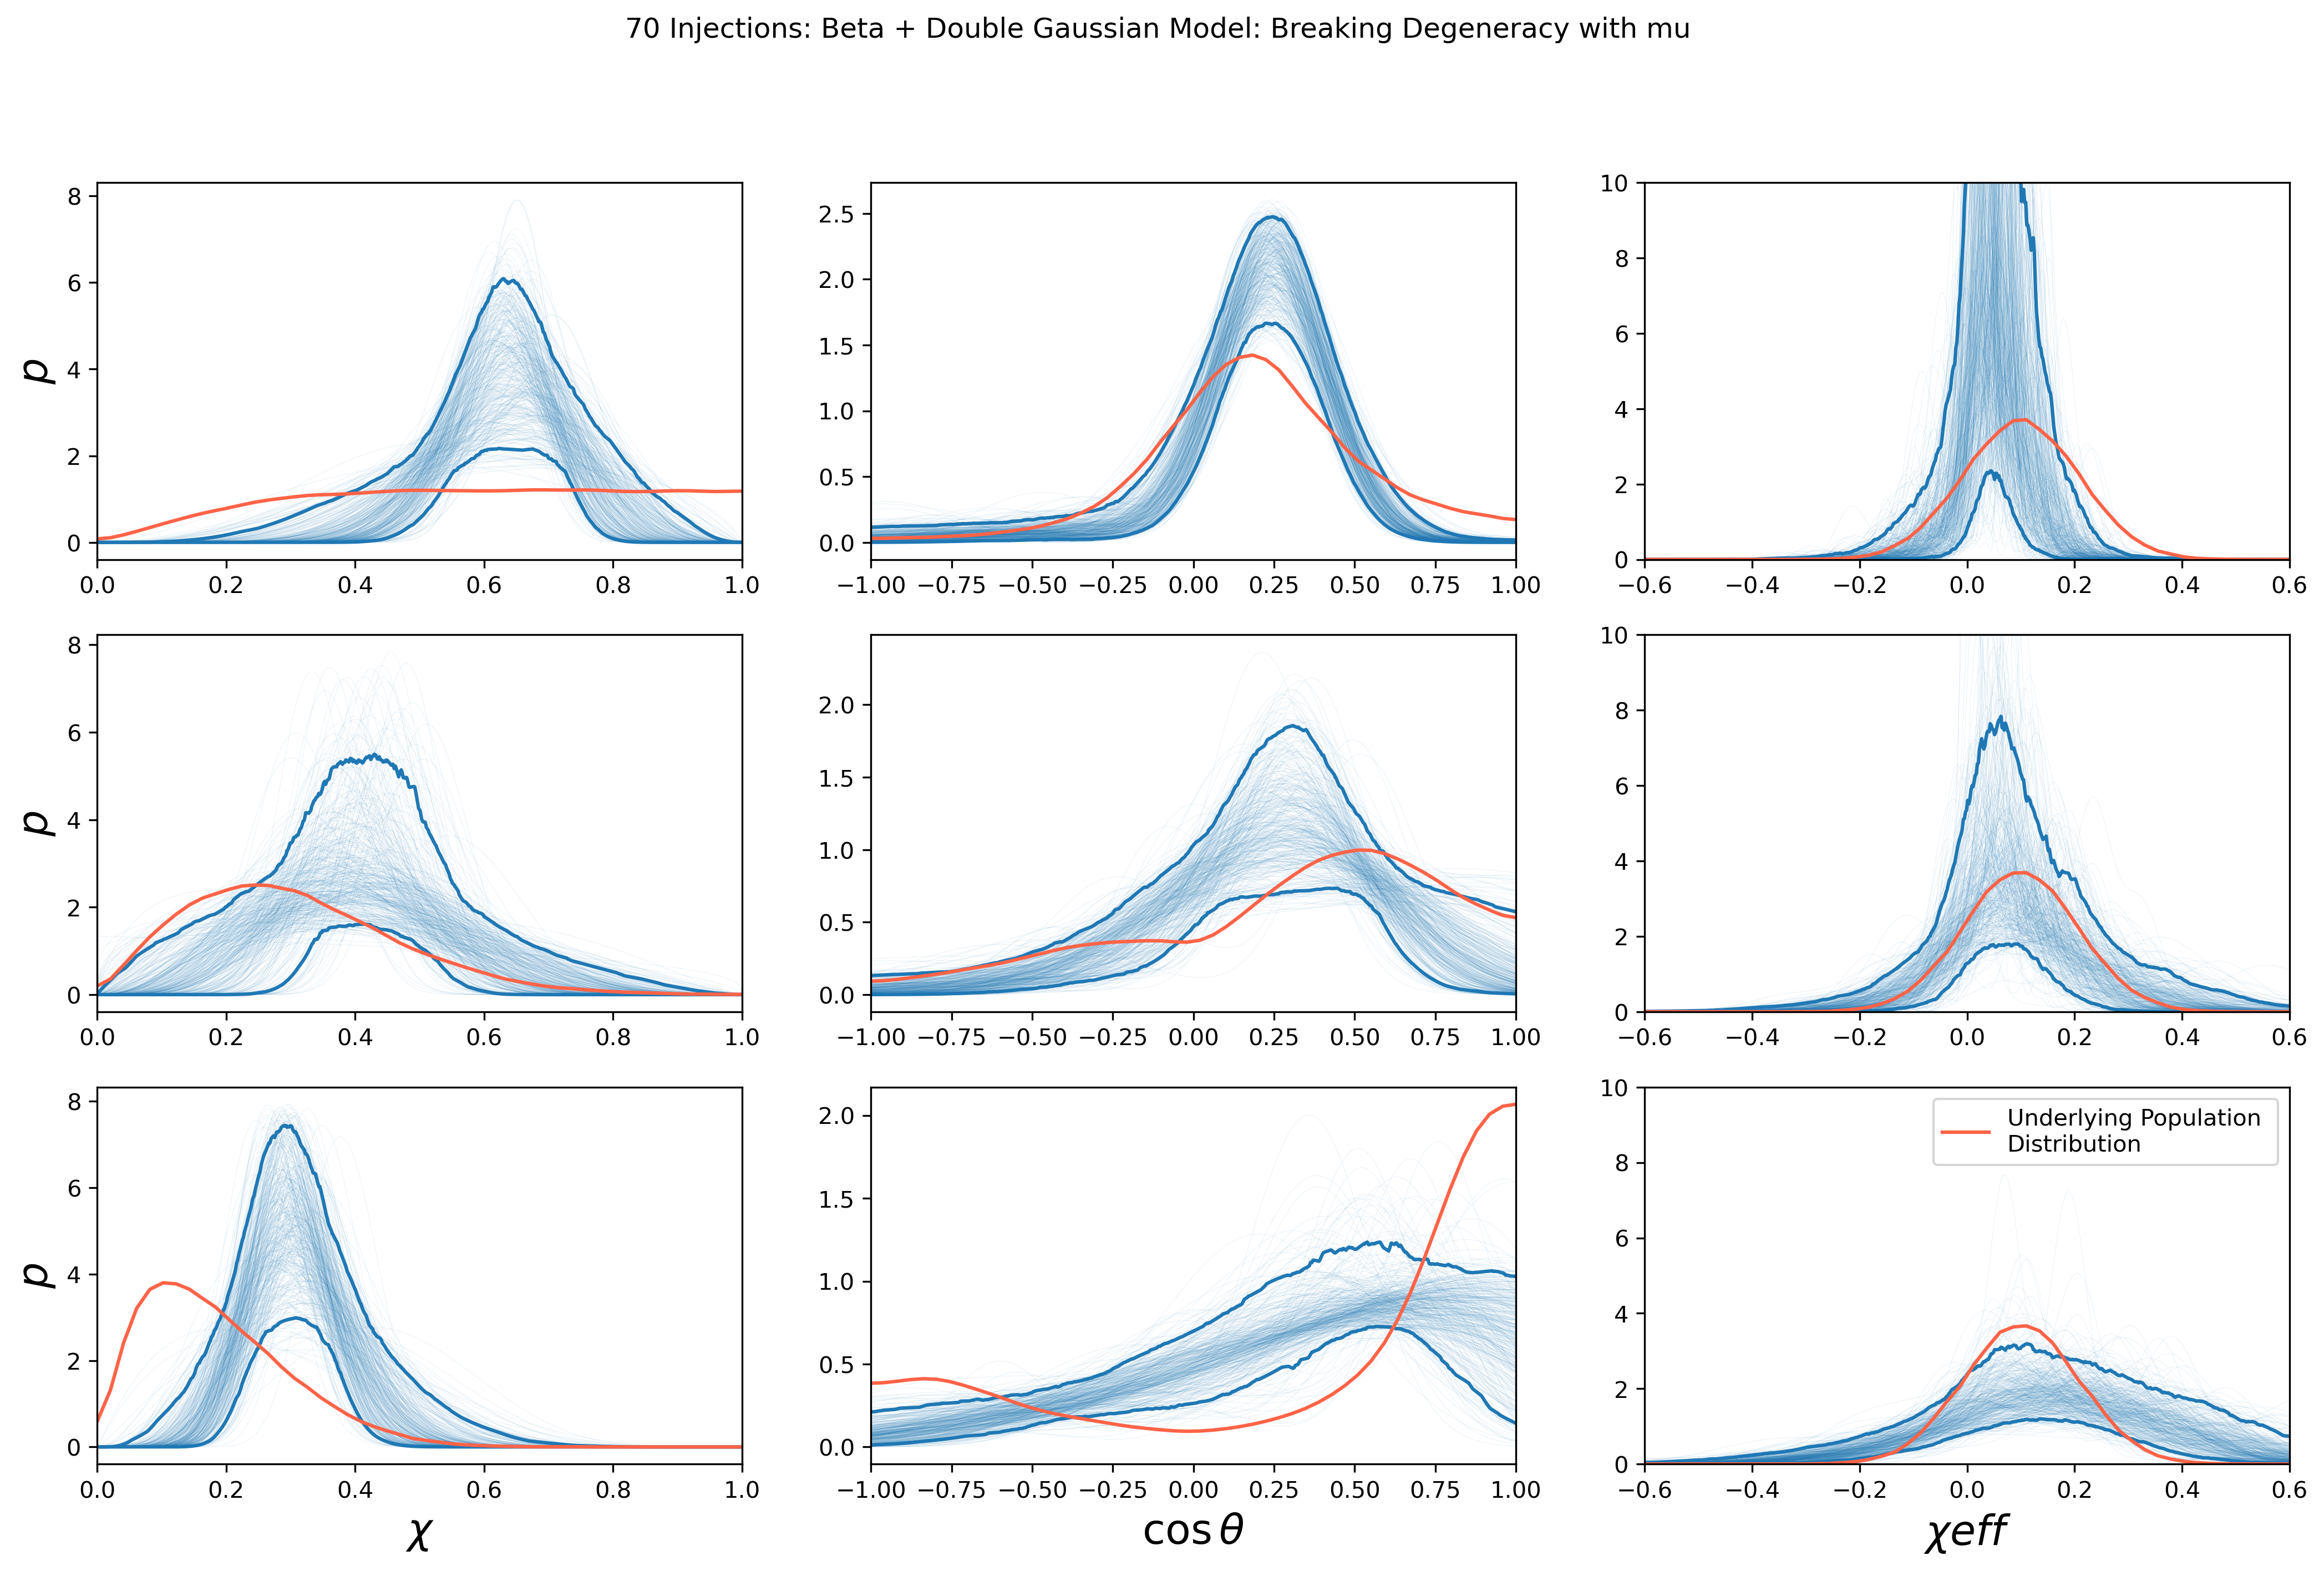

In [11]:
pop_kdes = '/home/zoe.ko/Xeff_injection_campaign/notebooks/pop_kdes/'

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17,10), dpi=300)

for i in np.arange(3):
    int_pop = i
    pop = str(i + 1)
    data = all_data[i]

    # Define a grid of effective spins
    chi_grid = np.linspace(0,1,1000)
    cost_grid = np.linspace(-1,1,1000)

    # Choose a number of traces to draw
    nTraces = 400

    # Instantiate an array to hold a collection of traces
    p_chi = np.zeros((nTraces,chi_grid.size))
    p_cost = np.zeros((nTraces,cost_grid.size))
    chieff_kdes_on_grid = np.zeros((nTraces,cost_grid.size))

    # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
    random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
    for i,ind in enumerate(random_indices):

        mu_chi = data['mu_chi']['processed'][ind]
        sigma_chi = data['sigma_chi']['processed'][ind]
        mu1_cost = data['mu1_cost']['processed'][ind]
        sigma1_cost = data['sigma1_cost']['processed'][ind]
        mu2_cost = data['mu2_cost']['processed'][ind]
        sigma2_cost = data['sigma2_cost']['processed'][ind]
        MF_cost = data['MF_cost']['processed'][ind]
        Bq = data['Bq']['processed'][ind]

        # calculate Beta distribution for chi
        a, b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
        p_chi[i,:] = betaDistribution(chi_grid, a, b)

        # and double Gaussian distribution for cos(theta)
        p_cost[i,:] = calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)

        # draw 500 chi-effective samples corresponding to the component spin distributions with hyper-parameters
        # {mu_chi, sigma_chi, MF_cost, sigma_cost, f_spike, sigma_spike, zmin, Bq,}
        chi_effs = drawChieffsDoubleGauss(mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, Bq, n=500)


        # calculate KDE from these draws and evaluate them on a grid of chi-effective values (i.e. chieff_grid = 
        # np.linspace(-1,1,100)
        chieff_grid = np.linspace(-1,1,1000)
        chieff_kde = gaussian_kde(chi_effs)
        chieff_kdes_on_grid[i,:] = chieff_kde(chieff_grid)

    chi_x = np.linspace(0, 1)
    chieff_x = np.linspace(-.6, .6)
    cost_x = np.linspace(-1, 1)

    chi_kde = np.load(pop_kdes + 'pop' + pop + '_chi_kde.npy')
    chieff_kde = np.load(pop_kdes + 'pop' + pop + '_chieff_kde.npy')
    cost_kde = np.load(pop_kdes + 'pop' + pop + '_cost_kde.npy')


    # Plot individual traces
    axes[int_pop][0].plot(chi_grid, p_chi.T,color='#1f78b4', lw=0.15, alpha=0.15, zorder=0)
    axes[int_pop][0].plot(chi_x, chi_kde, color='tomato', label='Underlying Population \nDistribution')

    axes[int_pop][1].plot(cost_grid, p_cost.T,color='#1f78b4', lw=0.15, alpha=0.15, zorder=0)
    axes[int_pop][1].plot(cost_x, cost_kde, color='tomato', label='Underlying Population \nDistribution')

    axes[int_pop][2].plot(chieff_grid, chieff_kdes_on_grid.T,color='#1f78b4', lw=0.15, alpha=0.15, zorder=0)
    axes[int_pop][2].plot(chieff_x, chieff_kde, color='tomato', label='Underlying Population \nDistribution')


    # Also plot 5% and 95% credible bounds
    axes[int_pop][0].plot(chi_grid,np.quantile(p_chi,0.05,axis=0),color='#1f78b4',zorder=1)
    axes[int_pop][0].plot(chi_grid,np.quantile(p_chi,0.95,axis=0),color='#1f78b4',zorder=1)
    axes[int_pop][1].plot(cost_grid,np.quantile(p_cost,0.05,axis=0),color='#1f78b4',zorder=1)
    axes[int_pop][1].plot(cost_grid,np.quantile(p_cost,0.95,axis=0),color='#1f78b4',zorder=1)
    axes[int_pop][2].plot(chieff_grid,np.quantile(chieff_kdes_on_grid,0.05,axis=0),color='#1f78b4',zorder=1)
    axes[int_pop][2].plot(chieff_grid,np.quantile(chieff_kdes_on_grid,0.95,axis=0),color='#1f78b4',zorder=1)
    
    axes[int_pop][0].set_xlim(0,1)
    axes[int_pop][1].set_xlim(-1,1)
    axes[int_pop][2].set_xlim(-0.6,0.6)
    axes[int_pop][2].set_ylim(0,10)

axes[2][0].set_xlabel(r'$\chi$',fontsize=18)
axes[0][0].set_ylabel(r'$p$',fontsize=18)
axes[2][1].set_xlabel(r'$\cos \theta$',fontsize=18)
axes[1][0].set_ylabel(r'$p$',fontsize=18)
axes[2][2].set_xlabel(r'$\chi eff$',fontsize=18)
axes[2][0].set_ylabel(r'$p$',fontsize=18)
plt.suptitle('70 Injections: Beta + Double Gaussian Model: Breaking Degeneracy with mu')
plt.legend()
plt.show()

pop 1


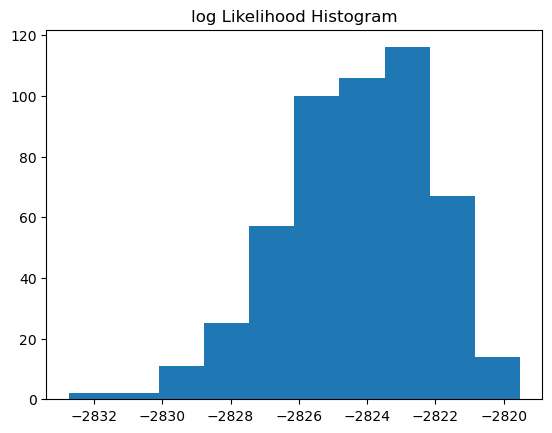

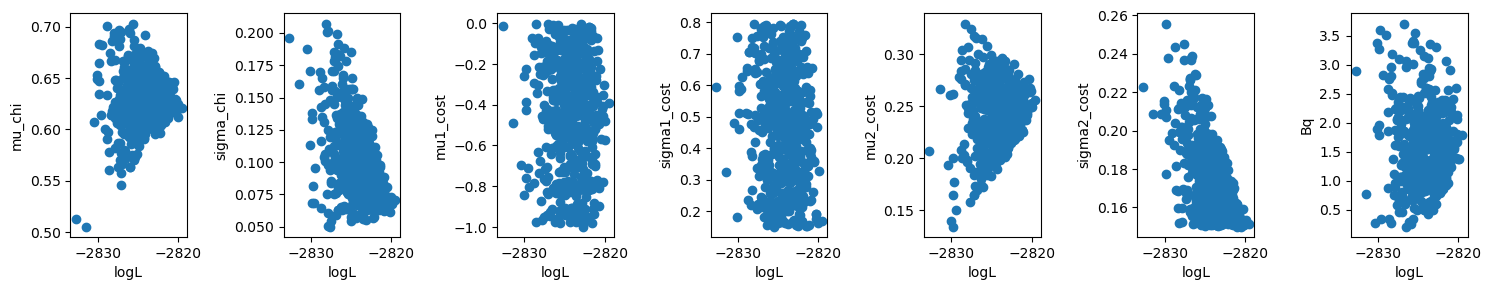

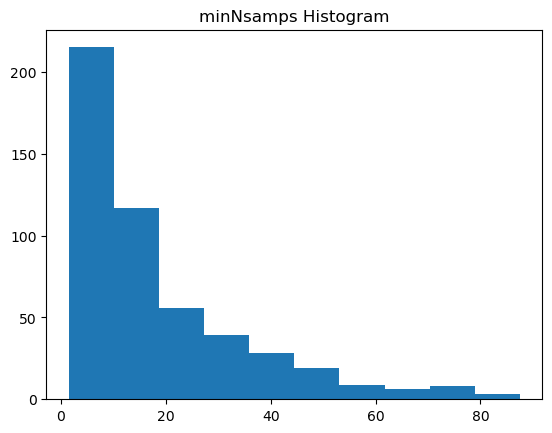

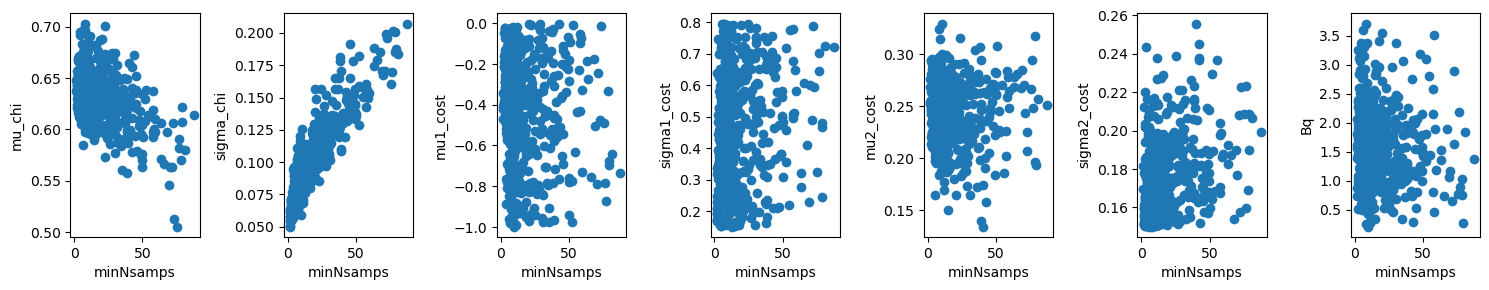

pop 2


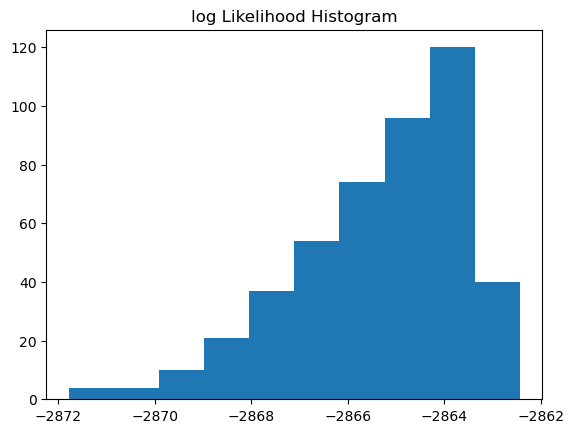

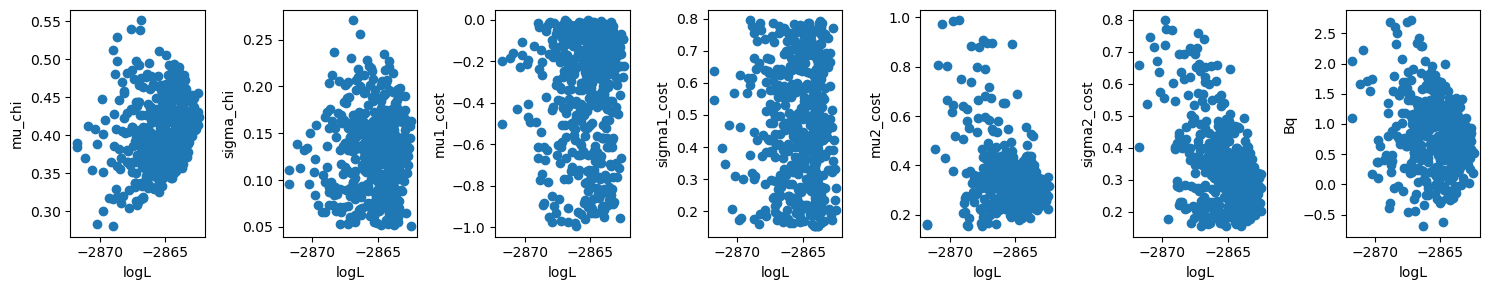

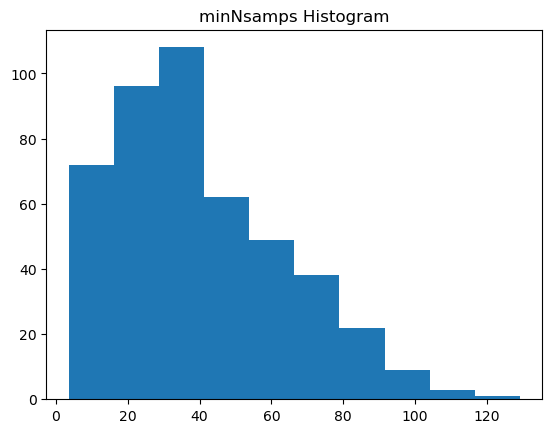

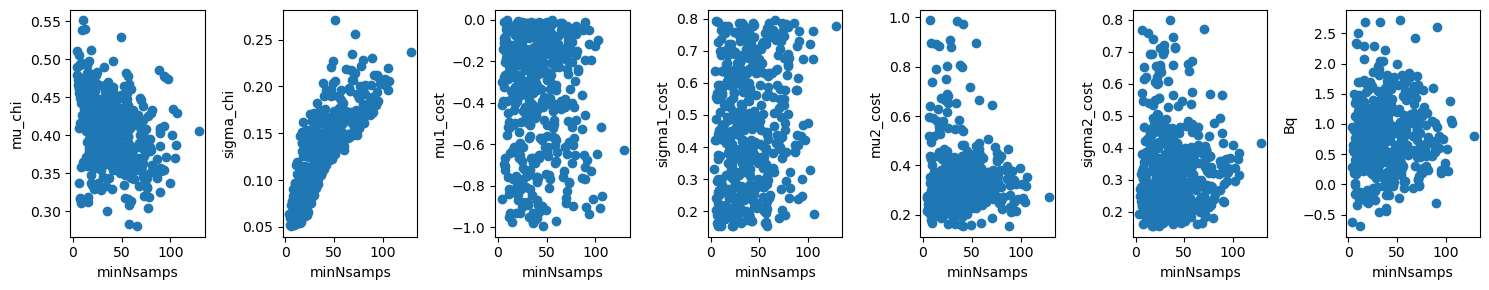

pop 3


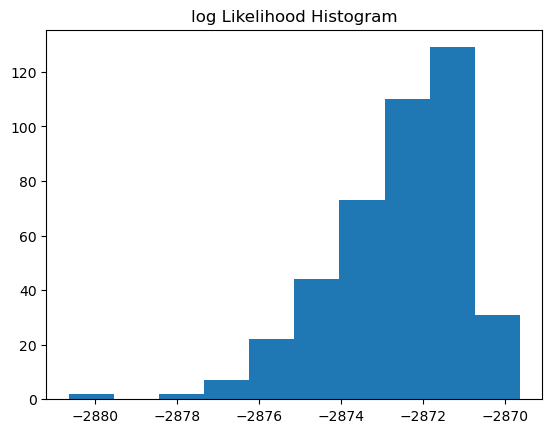

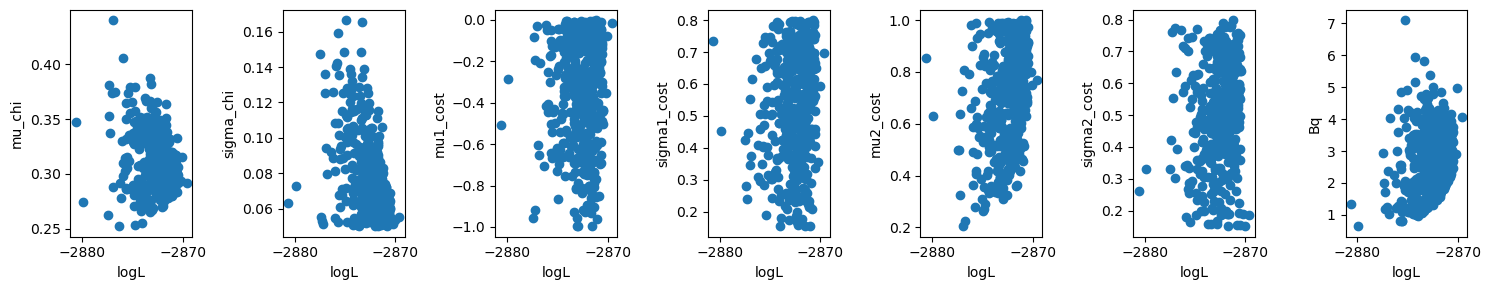

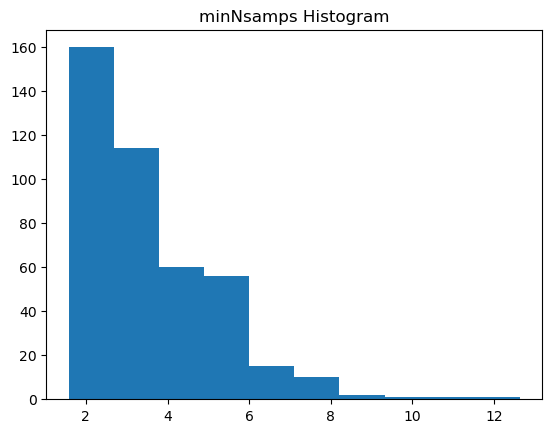

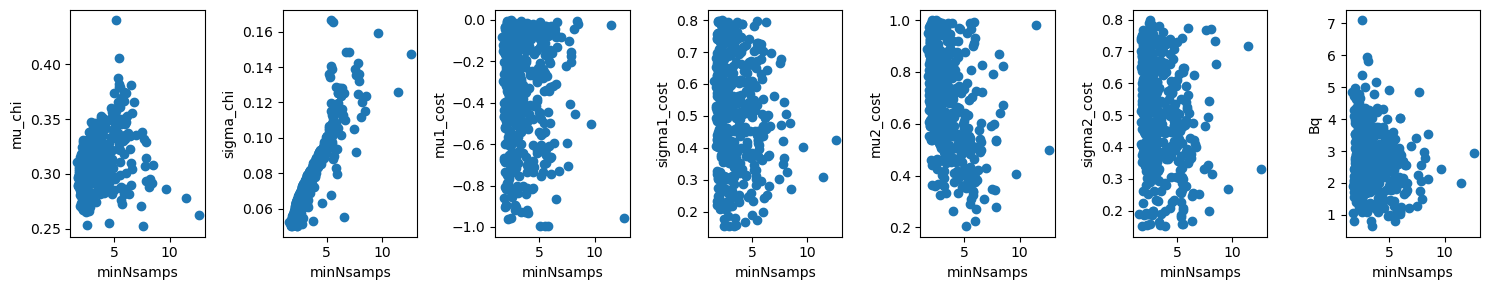

In [12]:
for i in np.arange(3):
    pop = str(i + 1)
    data = all_data[i]
    print(f'pop {pop}')
    
    mu_chi = data['mu_chi']['processed']
    sigma_chi = data['sigma_chi']['processed']
    mu1_cost = data['mu1_cost']['processed']
    sigma1_cost = data['sigma1_cost']['processed']
    mu2_cost = data['mu2_cost']['processed']
    sigma2_cost = data['sigma2_cost']['processed']
    Bq = data['Bq']['processed']
    
    params = ['mu_chi', 'sigma_chi', 'mu1_cost', 'sigma1_cost', 'mu2_cost', 'sigma2_cost', 'Bq']
    
    logL = data['logL']
    minNsamps = data['minNsamps']
    Neff = data['Neff']
    
    plt.hist(logL)
    plt.title('log Likelihood Histogram')
    plt.show()
    
    fig, axs = plt.subplots(1, 7, figsize=(15, 3))
    for i, param in enumerate(params):
        param_data = data[param]['processed']
        axs[i].scatter(logL, param_data)
        axs[i].set_xlabel('logL')
        axs[i].set_ylabel(param)
    plt.tight_layout()
    plt.show()
    
    plt.hist(minNsamps)
    plt.title('minNsamps Histogram')
    plt.show()   
    
    fig, axs = plt.subplots(1, 7, figsize=(15, 3))
    for i, param in enumerate(params):
        param_data = data[param]['processed']
        axs[i].scatter(minNsamps, param_data)
        axs[i].set_xlabel('minNsamps')
        axs[i].set_ylabel(param)
    plt.tight_layout()
    plt.show()

In [13]:
# plt.rcParams.update({'font.size': 16})

# pop_cdfs = '/home/zoe.ko/Xeff_injection_campaign/notebooks/pop_cdfs/'

# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17,10), dpi=300)

# for i in np.arange(3):
#     int_pop = i
#     pop = str(i + 1)
#     data = all_data[i]

#     # Define a grid of effective spins
#     chi_grid = np.linspace(0,1,1000)
#     cost_grid = np.linspace(-1,1,1000)

#     # Choose a number of traces to draw
#     nTraces = 500

#     # Instantiate an array to hold a collection of traces
#     p_chi = np.zeros((nTraces,chi_grid.size))
#     p_cost = np.zeros((nTraces,cost_grid.size))
#     chieff_kdes_on_grid = np.zeros((nTraces,cost_grid.size))

#     # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
#     random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
#     for i,ind in enumerate(random_indices):

#         mu_chi = data['mu_chi']['processed'][ind]
#         sigma_chi = data['sigma_chi']['processed'][ind]
#         mu1_cost = data['mu1_cost']['processed'][ind]
#         sigma1_cost = data['sigma1_cost']['processed'][ind]
#         mu2_cost = data['mu2_cost']['processed'][ind]
#         sigma2_cost = data['sigma2_cost']['processed'][ind]
#         MF_cost = data['MF_cost']['processed'][ind]
#         Bq = data['Bq']['processed'][ind]

#         # calculate Beta distribution for chi
#         a, b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
#         p_chi[i,:] = betaDistribution(chi_grid, a, b)

#         # and double Gaussian distribution for cos(theta)
#         p_cost[i,:] = calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)

#         # draw 500 chi-effective samples corresponding to the component spin distributions with hyper-parameters
#         # {mu_chi, sigma_chi, MF_cost, sigma_cost, f_spike, sigma_spike, zmin, Bq,}
#         chi_effs = drawChieffsDoubleGauss(mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, Bq, n=500)
        
#         # calculate KDE from these draws and evaluate them on a grid of chi-effective values (i.e. chieff_grid = 
#         # np.linspace(-1,1,100)
#         chieff_grid = np.linspace(-1,1,1000)
#         chieff_kde = gaussian_kde(chi_effs)
#         chieff_kdes_on_grid[i,:] = chieff_kde(chieff_grid)

#     chi_x = np.linspace(0, 1)
#     chieff_x = np.linspace(-.6, .6)
#     cost_x = np.linspace(-1, 1)

#     chi_cdf = np.load(pop_cdfs + 'pop' + pop + '_chi_cdf.npy')
#     chieff_cdf = np.load(pop_cdfs + 'pop' + pop + '_chieff_cdf.npy')
#     cost_cdf = np.load(pop_cdfs + 'pop' + pop + '_cost_cdf.npy')


#     # Plot individual traces

#     new_arr = []
#     for arr in p_chi:
#         x = np.cumsum(arr)*(chi_grid[1]-chi_grid[0])
#         new_arr = new_arr + [x]
#     new_arr = np.array(new_arr)
    
#     cdf = np.cumsum(p_chi.T)*(chi_grid[1]-chi_grid[0])
#     axes[int_pop][0].plot(chi_grid, new_arr.T, linewidth=0.65, alpha = 0.05, zorder=3)
#     axes[int_pop][0].plot(chi_x, chi_cdf, color='tomato', label='Underlying Population \nDistribution')


#     new_arr = []
#     for arr in p_cost:
#         x = np.cumsum(arr)*(cost_grid[1]-cost_grid[0])
#         new_arr = new_arr + [x]
#     new_arr = np.array(new_arr)
    
#     cdf = np.cumsum(p_cost.T)*(cost_grid[1]-cost_grid[0])
#     axes[int_pop][1].plot(cost_grid, new_arr.T, linewidth=0.65, alpha = 0.05, zorder=3)
#     axes[int_pop][1].plot(cost_x, cost_cdf, color='tomato', label='Underlying Population \nDistribution')

    
#     new_arr = []
#     for arr in chieff_kdes_on_grid:
#         x = np.cumsum(arr)*(chieff_grid[1]-chieff_grid[0])
#         new_arr = new_arr + [x]
#     new_arr = np.array(new_arr)
    
#     cdf = np.cumsum(chieff_kdes_on_grid.T)*(chieff_grid[1]-chieff_grid[0])
#     axes[int_pop][2].plot(chieff_grid, new_arr.T, linewidth=0.65, alpha = 0.05, zorder=3)
#     axes[int_pop][2].plot(chieff_x, chieff_cdf, color='tomato', label='Underlying Population \nDistribution')


# axes[2][0].set_xlabel(r'$\chi$',fontsize=18)
# axes[0][0].set_ylabel(r'$p$',fontsize=18)
# axes[2][1].set_xlabel(r'$\cos \theta$',fontsize=18)
# axes[1][0].set_ylabel(r'$p$',fontsize=18)
# axes[2][2].set_xlabel(r'$\chi eff$',fontsize=18)
# axes[2][0].set_ylabel(r'$p$',fontsize=18)
# plt.suptitle('70 Injections: Beta + Double Gaussian Model')
# plt.legend()
# plt.show()

# Posterior Predictive Plot

## Make PP Plot

In [14]:
# plt.rcParams.update({'font.size': 28})
# fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(37,20), dpi=300)

# for runs in np.arange(100):
#     all_chi1_pred = []
#     all_chi2_pred = []
#     all_cost1_pred = []
#     all_cost2_pred = []
#     all_chieff_pred = []

#     all_chi1_obs = []
#     all_chi2_obs = []
#     all_cost1_obs = []
#     all_cost2_obs = []
#     all_chieff_obs = []

#     for int_pop in np.arange(3):

#         pop = str(int_pop+1)

#         data = all_data[int_pop]

#         chi1_pred = []
#         chi2_pred = []
#         cost1_pred = []
#         cost2_pred = []
#         chieff_pred = []

#         # Define a grid of effective spins
#         chi_grid = np.linspace(0,1,1000)
#         cost_grid = np.linspace(-1,1,1000)

#         # Choose a number of traces to draw
#         nTraces = int(numinjections)
#         n = 1

#         # Instantiate an array to hold a collection of traces
#         p_chi = np.zeros((nTraces,chi_grid.size))
#         p_cost = np.zeros((nTraces,cost_grid.size))
#         chieff_kdes_on_grid = np.zeros((nTraces,cost_grid.size))

#         # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
#         random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
#         for i,ind in enumerate(random_indices):

#             mu_chi = data['mu_chi']['processed'][ind]
#             sigma_chi = data['sigma_chi']['processed'][ind]
#             mu1_cost = data['mu1_cost']['processed'][ind]
#             sigma1_cost = data['sigma1_cost']['processed'][ind]
#             mu2_cost = data['mu2_cost']['processed'][ind]
#             sigma2_cost = data['sigma2_cost']['processed'][ind]
#             MF_cost = data['MF_cost']['processed'][ind]
#             Bq = data['Bq']['processed'][ind]

#             # calculate Beta distribution for chi
#             a, b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
#             p_chi[i,:] = betaDistribution(chi_grid, a, b)

#             # and double Gaussian distribution for cos(theta)
#             p_cost[i,:] = calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)


#             # draw uniform component spins + masses
#             nRandomDraws = 10000
#             samp_idxs = np.arange(nRandomDraws)
#             chi1s = np.random.rand(nRandomDraws)
#             chi2s = np.random.rand(nRandomDraws)
#             cost1s = np.random.rand(nRandomDraws)*2 - 1
#             cost2s = np.random.rand(nRandomDraws)*2 - 1
#             mAs = np.random.rand(nRandomDraws)*100
#             mBs = np.random.rand(nRandomDraws)*100
#             m1s = np.maximum(mAs, mBs)
#             m2s = np.minimum(mAs, mBs)


#             p_chi1 = calculate_Double_Gaussian(chi1s, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)
#             p_chi2 = calculate_Double_Gaussian(chi2s, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)
#             p_cost1 = calculate_Double_Gaussian(cost1s, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)
#             p_cost2 = calculate_Double_Gaussian(cost2s, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)
#             p_masses = p_astro_masses(m1s, m2s, bq=Bq)

#             weights = p_chi1*p_chi2*p_cost1*p_cost2*p_masses
#             weights_normed = weights/np.sum(weights)
#             weights_normed[np.where(weights_normed<0)] = 0 # get rid of tiny division errors

#             # select a subset of the samples subject to the weights
#             # calculated from p(spins,masses)
#             idxs = np.random.choice(samp_idxs, p=weights_normed, size=n)  

#             # calculate chi-eff for these samples
#             q = m2s[idxs]/m1s[idxs]
#             chi_eff = (chi1s[idxs]*cost1s[idxs] + q*chi2s[idxs]*cost2s[idxs])/(1+q)

#             chi1 = chi1s[idxs]
#             chi2 = chi2s[idxs]
#             cost1 = cost1s[idxs]
#             cost2 = cost2s[idxs]

#             chi1_pred = np.append(chi1_pred, chi1)
#             chi2_pred = np.append(chi2_pred, chi2)
#             cost1_pred = np.append(cost1_pred, cost1)
#             cost2_pred = np.append(cost2_pred, cost2)
#             chieff_pred = np.append(chieff_pred, chi_eff)



#             # draw 500 chi-effective samples corresponding to the component spin distributions with hyper-parameters
#             # {mu_chi, sigma_chi, MF_cost, sigma_cost, f_spike, sigma_spike, zmin, Bq,}
#             chi_effs = drawChieffsDoubleGauss(mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, Bq, n=500)


#             # calculate KDE from these draws and evaluate them on a grid of chi-effective values (i.e. chieff_grid = 
#             # np.linspace(-1,1,100)
#             chieff_grid = np.linspace(-1,1,1000)
#             chieff_kde = gaussian_kde(chi_effs)
#             chieff_kdes_on_grid[i,:] = chieff_kde(chieff_grid)



#         all_chi1_pred += [chi1_pred]
#         all_chi2_pred += [chi2_pred]
#         all_cost1_pred += [cost1_pred]
#         all_cost2_pred += [cost2_pred]
#         all_chieff_pred += [chieff_pred]





#         sampleDict_rw = np.load(data_folder + 'pop' + pop
#                                 + 'rw_sampleDict.pickle', allow_pickle=True)
#         chi1_obs = []
#         chi2_obs = []
#         cost1_obs = []
#         cost2_obs = []
#         chieff_obs = []

#         for key in sampleDict_rw.keys():
#             d = sampleDict_rw[key]
#             chi1 = random.choice(d['chi1'])
#             chi1_obs += [chi1]
#             chi2 = random.choice(d['chi2'])
#             chi2_obs += [chi2]
#             cost1 = random.choice(d['cost1'])
#             cost1_obs += [cost1]
#             cost2 = random.choice(d['cost2'])
#             cost2_obs += [cost2]

#         all_chi1_obs += chi1_obs
#         all_chi2_obs += chi2_obs
#         all_cost1_obs += cost1_obs
#         all_cost2_obs += cost2_obs
#         all_chieff_obs += chieff_obs
    
        
#         axes[int_pop][0].plot(np.sort(chi1_pred), np.sort(chi1_obs), alpha=0.3, c='cornflowerblue')
#         axes[int_pop][0].plot(np.sort(chi1_pred), np.sort(chi1_pred), alpha = 0.3, ls='--', c='tomato')
#         axes[int_pop][0].set_xlabel('Predicted Value')
#         axes[int_pop][0].set_ylabel('Observed Value')
#         axes[int_pop][0].set_title('Chi 1')
        
#         axes[int_pop][1].plot(np.sort(chi2_pred), np.sort(chi2_obs), alpha=0.3, c='cornflowerblue')
#         axes[int_pop][1].plot(np.sort(chi2_pred), np.sort(chi2_pred), alpha = 0.3, ls='--', c='tomato')
#         axes[int_pop][1].set_xlabel('Predicted Value')
#         axes[int_pop][1].set_ylabel('Observed Value')
#         axes[int_pop][1].set_title('Chi 2')        

#         axes[int_pop][2].plot(np.sort(cost1_pred), np.sort(cost1_obs), alpha=0.3, c='cornflowerblue')
#         axes[int_pop][2].plot(np.sort(cost1_pred), np.sort(cost1_pred), alpha = 0.3, ls='--', c='tomato')
#         axes[int_pop][2].set_xlabel('Predicted Value')
#         axes[int_pop][2].set_ylabel('Observed Value')
#         axes[int_pop][2].set_title('Cost 1')
        
#         axes[int_pop][3].plot(np.sort(cost2_pred), np.sort(cost2_obs), alpha=0.3, c='cornflowerblue')
#         axes[int_pop][3].plot(np.sort(cost2_pred), np.sort(cost2_pred), alpha = 0.3, ls='--', c='tomato')
#         axes[int_pop][3].set_xlabel('Predicted Value')
#         axes[int_pop][3].set_ylabel('Observed Value')
#         axes[int_pop][3].set_title('Cost 2')

# axes[0][0].set_ylabel('Pop 1: Observed Value')
# axes[1][0].set_ylabel('Pop 2: Observed Value')
# axes[2][0].set_ylabel('Pop 3: Observed Value')

# plt.tight_layout()
# plt.suptitle('70 Injections: Beta + Double Gaussian Model', y = 1.05)
# plt.show()